In [8]:
####
# @Author: David Hsien
# @Date: 2018/11/19
# @Description: A playground for GRU
####

%matplotlib inline
import torch
import torch.nn as nn
import torch.nn.functional as F
import pickle as pk
from pprint import pprint
import numpy as np
import pandas as pd
from datetime import datetime
from datetime import timedelta
from tqdm import tqdm
import torch.optim as optim
from torch.autograd import Variable
from random import randint
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import random

In [9]:
class PM25Dataset(Dataset):
    
    def __init__(self, file_name):
        with open(file_name, "rb") as file:
            self.Data = pk.load(file)
        
    def __len__(self):
        return self.Data.shape[0] - 37
    
    def __getitem__(self, idx):
        
        training_d = self.Data.iloc[idx : idx + 24].values.astype('float32')
        label_d = self.Data['PM2.5'].iloc[idx + 24 : idx + 36].values.astype('float32')
        
        return torch.from_numpy(training_d), torch.from_numpy(label_d)

In [10]:
with open("All_PM25_data_DataFrame_training_Tainan.pk", "rb") as file:
    data = pk.load(file)
    print(data.head())

feature              AMB_TEMP       NOx      PM10     PM2.5        RH  \
2014-01-01 00:00:00  0.250000  0.292453  0.220588  0.148368  0.806122   
2014-01-01 01:00:00  0.233333  0.330189  0.205882  0.157270  0.826531   
2014-01-01 02:00:00  0.233333  0.396226  0.223039  0.204748  0.836735   
2014-01-01 03:00:00  0.233333  0.349057  0.245098  0.207715  0.836735   
2014-01-01 04:00:00  0.233333  0.386792  0.267157  0.198813  0.836735   

feature                   SO2  WIND_SPEED  WIND_DIREC_COS  WIND_DIREC_SIN  \
2014-01-01 00:00:00  0.077778    0.176923        0.777146        0.629320   
2014-01-01 01:00:00  0.074603    0.115385        0.906308        0.422618   
2014-01-01 02:00:00  0.087302    0.130769        0.766044        0.642788   
2014-01-01 03:00:00  0.084127    0.161538        0.777146        0.629320   
2014-01-01 04:00:00  0.095238    0.184615        0.559193        0.829038   

feature              PM2.5_diff  
2014-01-01 00:00:00    0.506494  
2014-01-01 01:00:00    0.50649

In [11]:
data_set = PM25Dataset("All_PM25_data_DataFrame_training_Tainan.pk")
validation_set = PM25Dataset("All_PM25_data_DataFrame_validation_Tainan.pk")

dataloader = DataLoader(data_set, batch_size = 500, shuffle= True, num_workers = 10)
validation_dataloader = DataLoader(validation_set, batch_size = 500, shuffle= True, num_workers = 10)

In [45]:
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

print(device)

class PM25EncoderDecoder(nn.Module):
    
    def __init__(self):
        super(PM25EncoderDecoder, self).__init__()
        self.hidden_size = 48
        self.layer = 4
        self.feature_num = 10
        self.time_step = 24
        self.teacher_forcing_ratio = 0.5
        #GRU Encoder
        self.GRU_E = nn.GRU(self.feature_num, self.hidden_size, self.layer,
                            batch_first = True, bidirectional = True)
        self.GRU_D = nn.GRU(1 + self.hidden_size * 2, self.hidden_size, self.layer,
                            batch_first = True, bidirectional = True)
        self.fc1_D = nn.Linear(self.hidden_size * 2 + 1, self.hidden_size)#Bidirectional
        self.fc2_D = nn.Linear(self.hidden_size, 1)
        
    def forward(self, x, hidden_state = None, label = None, u_t_f = False):
        
        input_tensor = x.view(-1, self.time_step, self.feature_num)
        
        GRU_out, hidden_state = self.GRU_E(input_tensor, hidden_state)
        total_output = torch.tensor(()).float().to(device)
        
        use_teacher_forcing = True if random.random() > self.teacher_forcing_ratio else False
        #input_ = torch.empty((input_tensor.shape[0], 1)).float().to(device)
        #input_.fill_(0)
        input_ = x[:, -1, 3]
        
        for time_step in range(12):
            output, hidden_state = self.decoder_forward_step(input_, hidden_state, GRU_out[:, -1, :])
            if use_teacher_forcing and u_t_f:
                input_ = label[:, time_step]
            else:
                input_ = output
            total_output = torch.cat((total_output, output), 1)
        return total_output, hidden_state
    
    def decoder_forward_step(self, x, hidden_state = None, context_vector = None):
        input_data = torch.cat((context_vector.view(-1, 1, self.hidden_size * 2), x.view(-1, 1, 1)), 2)
        GRU_out, hidden_state = self.GRU_D(input_data, hidden_state)
        output = F.relu(self.fc1_D(torch.cat((GRU_out, x.view(-1, 1, 1)), 2)))
        output = F.relu(self.fc2_D(output))
        return output, hidden_state

model = PM25EncoderDecoder()
#model.load_state_dict(torch.load('/home/kddteam2/QQAQ_OnlineService/data/model.dict'))
model.to(device)
model

cuda:1


PM25EncoderDecoder(
  (GRU_E): GRU(10, 48, num_layers=4, batch_first=True, bidirectional=True)
  (GRU_D): GRU(97, 48, num_layers=4, batch_first=True, bidirectional=True)
  (fc1_D): Linear(in_features=97, out_features=48, bias=True)
  (fc2_D): Linear(in_features=48, out_features=1, bias=True)
)

Epoch:  0


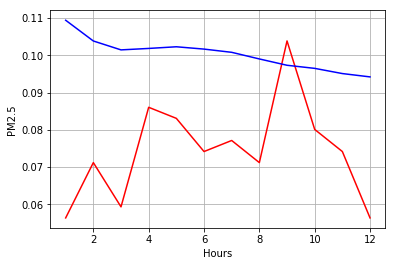

0.006905495934188366


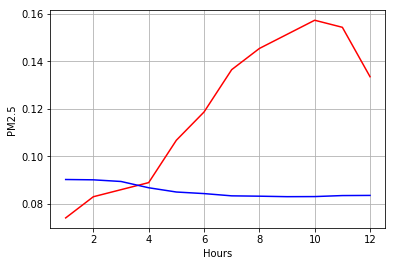

0.004566144978161902
valid: tensor(7.0370, device='cuda:1')
1hr_loss tensor(6.4618, device='cuda:1')


/home/kddteam2/anaconda3/envs/air_quality_cmaq/lib/python3.6/site-packages/ipykernel_launcher.py:62: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/home/kddteam2/anaconda3/envs/air_quality_cmaq/lib/python3.6/site-packages/ipykernel_launcher.py:63: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


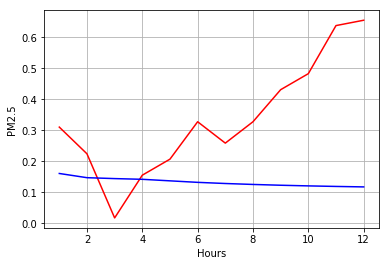

valid: tensor(7.2049, device='cuda:1')
1hr_loss tensor(5.9582, device='cuda:1')


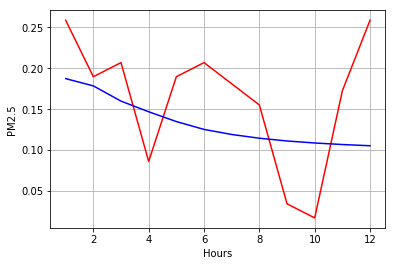

Epoch:  1


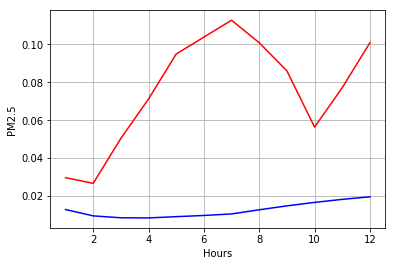

0.007356217503547669


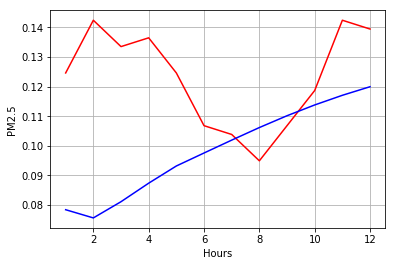

0.0030739566311240194
valid: tensor(6.4858, device='cuda:1')
1hr_loss tensor(5.7654, device='cuda:1')


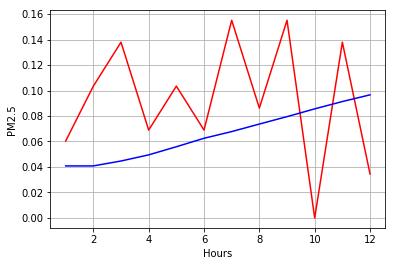

valid: tensor(6.7768, device='cuda:1')
1hr_loss tensor(5.4724, device='cuda:1')


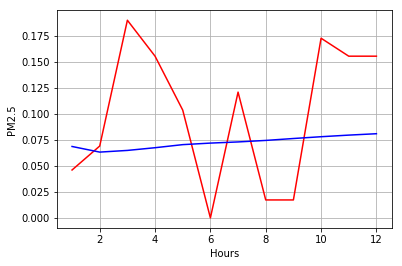

Epoch:  2


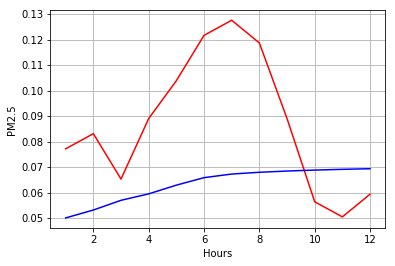

0.005937477096449584


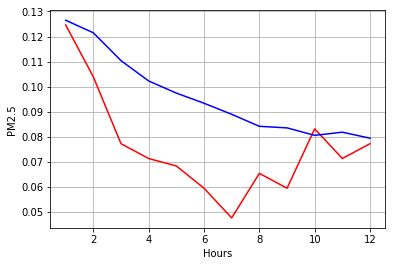

0.0027653618773911147
valid: tensor(6.7760, device='cuda:1')
1hr_loss tensor(6.0745, device='cuda:1')


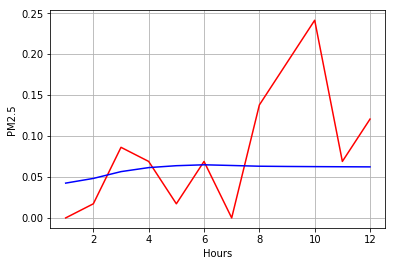

valid: tensor(7.2400, device='cuda:1')
1hr_loss tensor(6.2725, device='cuda:1')


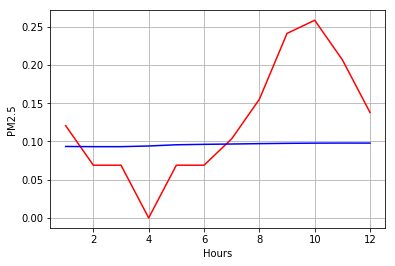

Epoch:  3


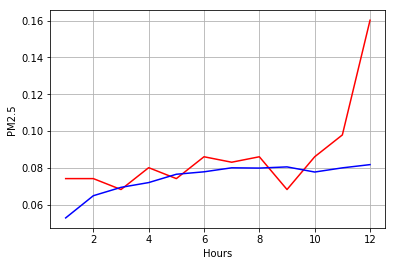

0.005514454224612564


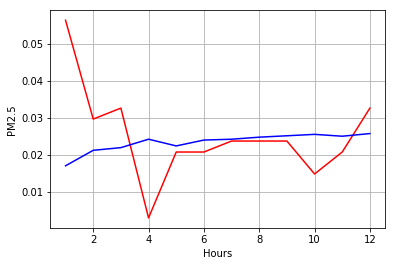

0.0024042939010541888
valid: tensor(7.8533, device='cuda:1')
1hr_loss tensor(6.7472, device='cuda:1')


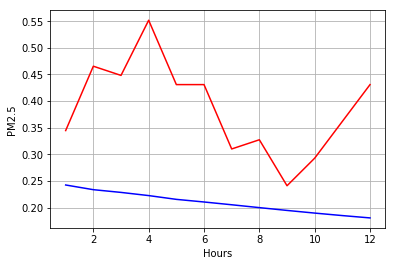

valid: tensor(8.3586, device='cuda:1')
1hr_loss tensor(6.5215, device='cuda:1')


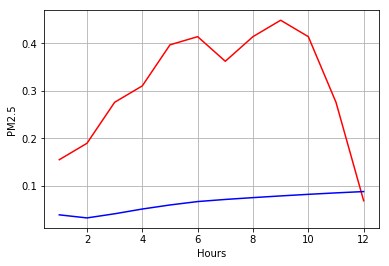

Epoch:  4


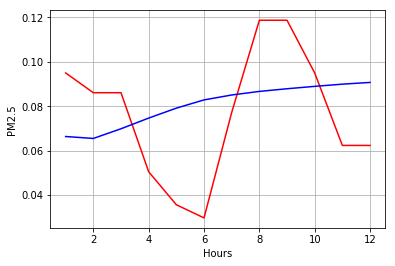

0.005355059652356431


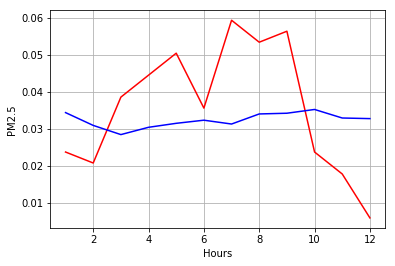

0.002725246024783701
valid: tensor(7.8756, device='cuda:1')
1hr_loss tensor(6.9269, device='cuda:1')


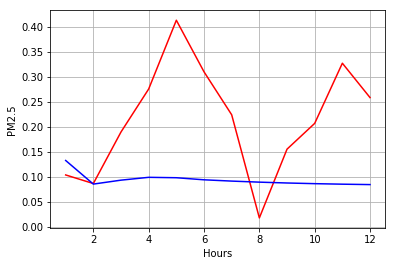

valid: tensor(8.0260, device='cuda:1')
1hr_loss tensor(6.4864, device='cuda:1')


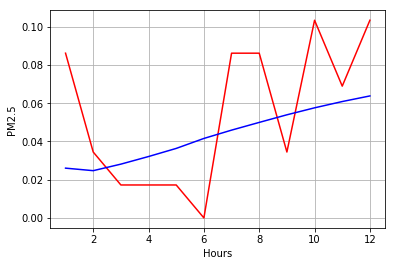

Epoch:  5


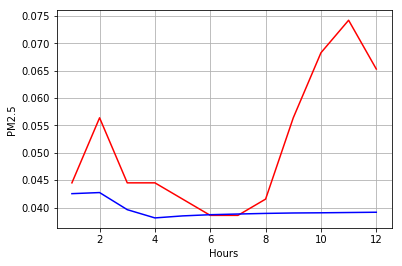

0.004478861863026396


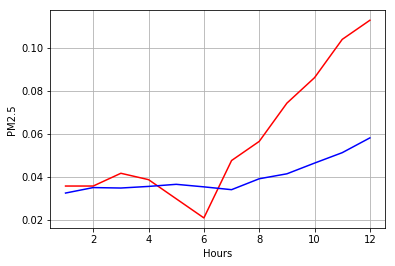

0.0023445314029231666
valid: tensor(7.3692, device='cuda:1')
1hr_loss tensor(5.8821, device='cuda:1')


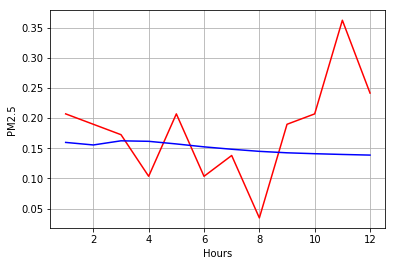

valid: tensor(7.4538, device='cuda:1')
1hr_loss tensor(6.3335, device='cuda:1')


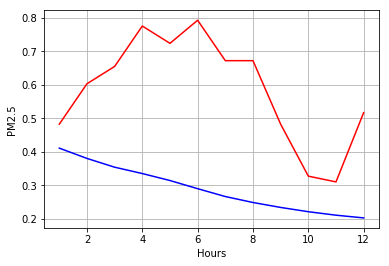

Epoch:  6


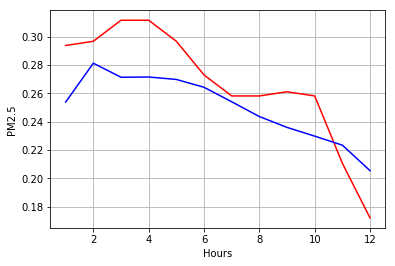

0.004896825616015121


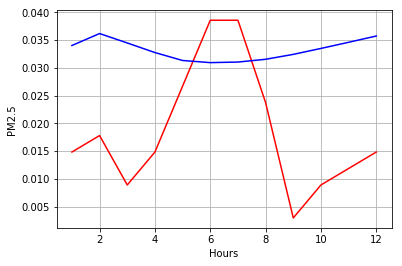

0.0025969019799958913
valid: tensor(7.5931, device='cuda:1')
1hr_loss tensor(6.5740, device='cuda:1')


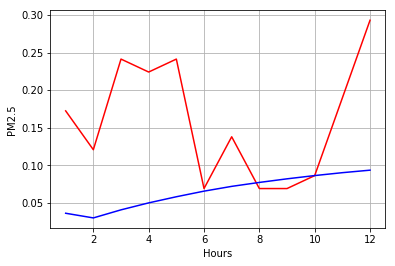

valid: tensor(8.0709, device='cuda:1')
1hr_loss tensor(6.5659, device='cuda:1')


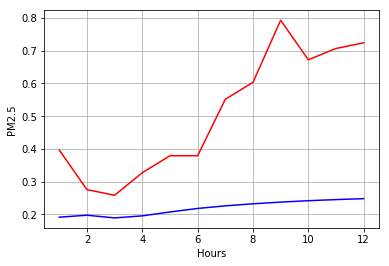

Epoch:  7


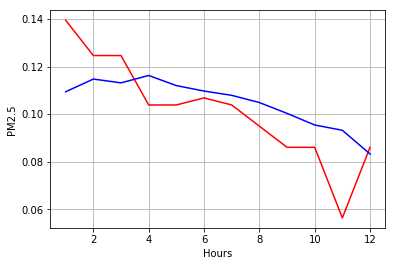

0.003992635454051196


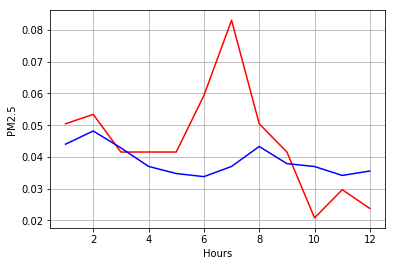

0.0024144805036485197
valid: tensor(7.9646, device='cuda:1')
1hr_loss tensor(6.2839, device='cuda:1')


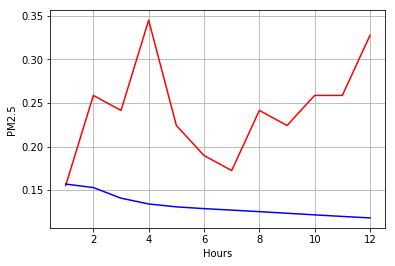

valid: tensor(7.5326, device='cuda:1')
1hr_loss tensor(6.0692, device='cuda:1')


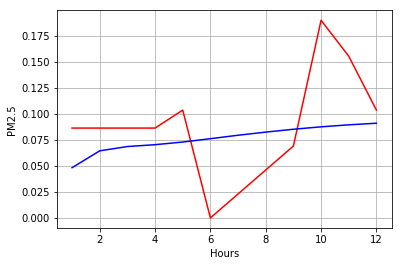

Epoch:  8


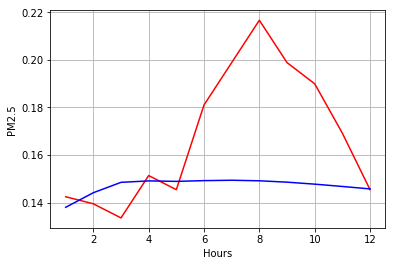

0.004696272540604696


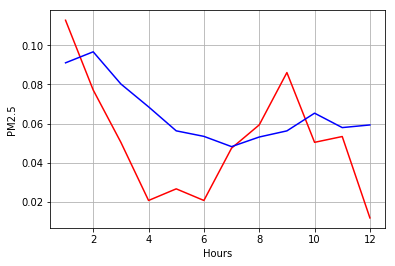

0.0020097573811654
valid: tensor(8.6610, device='cuda:1')
1hr_loss tensor(6.3139, device='cuda:1')


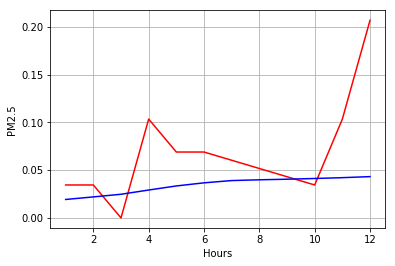

valid: tensor(8.7958, device='cuda:1')
1hr_loss tensor(6.2429, device='cuda:1')


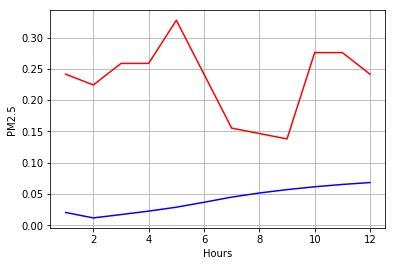

Epoch:  9


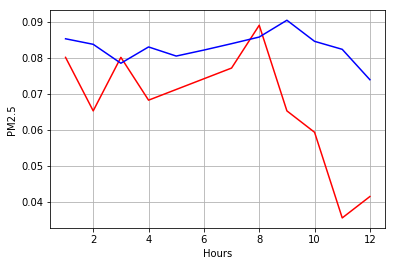

0.004339844459900632


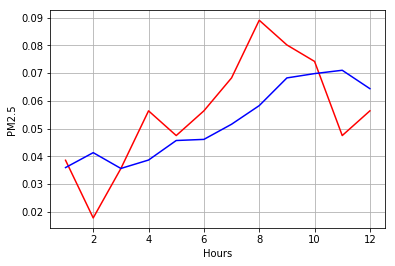

0.0023896728409454225
valid: tensor(8.1759, device='cuda:1')
1hr_loss tensor(6.2053, device='cuda:1')


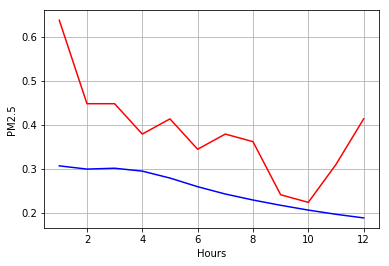

valid: tensor(7.8000, device='cuda:1')
1hr_loss tensor(5.8389, device='cuda:1')


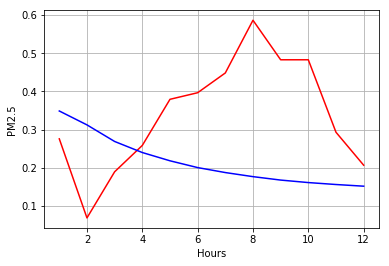

In [46]:
loss_function = nn.MSELoss()
valid_loss_function = nn.L1Loss(size_average=True)
optimizer = optim.Adam(model.parameters())
running_loss = 0
epoch = 10
steps = np.arange(1,13)

for e in range(epoch):
    #Get the data
    print("Epoch: ", e)
    for index, (training_data, label) in enumerate(dataloader):
        
        hidden_state = None
        
        data = np.flip(training_data.data.numpy(), 1).copy()

        #Zero out the grad in model
        optimizer.zero_grad()
    
        #Put them to GPU
        input_data = torch.from_numpy(data).float().to(device)
        label_data = label.float().to(device)

        #Feed the model
        output, hidden_state = model(input_data, hidden_state, label_data, True)
        hidden_state = hidden_state.detach()
        hidden_state = torch.autograd.Variable(hidden_state.data, requires_grad=True)
    
        #Train the model
        loss = loss_function(output.squeeze(2), label_data)
        loss.backward()

        running_loss += loss.item()
        optimizer.step()
    
        if index and index % 20 == 0:
            fig, ax = plt.subplots()
            ax.plot(steps, label_data[0].cpu().data.numpy(), 'r-', label='real')
            ax.plot(steps, output[0].cpu().data.numpy(), 'b-', label='pred')
            ax.set(xlabel="Hours",ylabel="PM2.5")
            ax.grid()
            plt.show()
            print(running_loss / 10)
            running_loss = 0
    
    #print("Validation:")
    for index, (validation_data, label) in enumerate(validation_dataloader):
        
        hidden_state = None
        
        data = np.flip(validation_data.data.numpy(), 1).copy()
        
        input_data = torch.from_numpy(data).float().to(device)
        label_data = label.float().to(device)
        
        output, hidden_state = model(input_data, hidden_state, label_data)
        
        if index:
            output = output.squeeze(2)
            loss = valid_loss_function(output, label_data)
            fhr_loss = valid_loss_function(output[:, 0], label_data[:, 0])
            print("valid:", loss.data[0] * 60)
            print("1hr_loss", fhr_loss.data[0] * 60)
            
            fig, ax = plt.subplots()
            ax.plot(steps, label_data[55].cpu().data.numpy(), 'r-', label='real')
            ax.plot(steps, output[55].cpu().data.numpy(), 'b-', label='pred')
            ax.set(xlabel="Hours",ylabel="PM2.5")
            ax.grid()
            plt.show()
        

In [7]:
torch.save(model.state_dict(), '/home/kddteam2/QQAQ_OnlineService/data/model.dict')

In [47]:
valid_loss_function = nn.L1Loss(size_average=True)
overall_loss = torch.Tensor([]).float().to(device)
f_hr_loss = torch.Tensor([]).float().to(device)
print("Validation:")
for index, (validation_data, label) in enumerate(validation_dataloader):
        
    hidden_state = None
        
    data = np.flip(validation_data.data.numpy(), 1).copy()
        
    input_data = torch.from_numpy(data).float().to(device)
    label_data = label.float().to(device)
        
    output, hidden_state = model(input_data, hidden_state, label_data)
    
    loss = valid_loss_function(output.squeeze(2), label_data)
    f_hr_loss = valid_loss_function(output[:, :6].squeeze(2), label_data[:, :6])
    
    overall_loss = torch.cat((loss.view(-1, 1), overall_loss))
    f_hr_loss = torch.cat((f_hr_loss.view(-1, 1), overall_loss))
        
    #if index and index % 10 == 0:
    #    fig, ax = plt.subplots()
    #    print(label_data[0])
    #    ax.plot(steps, label_data[0].cpu().data.numpy(), 'r-', label='real')
    #    ax.plot(steps, output[0].cpu().data.numpy(), 'b-', label='pred')
    #    ax.set(xlabel="Hours",ylabel="PM25")
    #    ax.grid()
    #    plt.show()

print(overall_loss.mean() * 60)
print(f_hr_loss.mean() * 60)

Validation:
tensor(7.7839, device='cuda:1', grad_fn=<MulBackward>)
tensor(7.6572, device='cuda:1', grad_fn=<MulBackward>)
